In [128]:
# 1) Install kagglehub if you haven't:
#    pip install kagglehub --upgrade
import os, shutil, zipfile, pandas as pd, kagglehub
from pathlib import Path


In [129]:
KAGGLE_SLUG = "vinitasilaparasetty/fitzpatrick-classification-by-ethnicity"
DEST        = Path("fitzpatrick17k")          # final clean layout
DEST.mkdir(exist_ok=True, parents=True)

# ── 2. Download (kagglehub auto-caches) ───────────────────────────────────
print("⏬  Downloading via kagglehub …")
dl_path = Path(
    kagglehub.dataset_download(KAGGLE_SLUG)   # returns cache path
)
print("KaggleHub cache folder:", dl_path)



⏬  Downloading via kagglehub …
KaggleHub cache folder: C:\Users\yrsee\.cache\kagglehub\datasets\vinitasilaparasetty\fitzpatrick-classification-by-ethnicity\versions\2


In [130]:
# ── 2. If a ZIP exists, unzip; else use the folder as-is ──────────────────
zip_candidates = list(dl_path.glob("*.zip"))
if zip_candidates:
    zip_file = zip_candidates[0]
    print("📦  Extracting", zip_file.name)
    with zipfile.ZipFile(zip_file) as zf:
        zf.extractall(DEST)
else:
    # The dataset is already extracted → copy contents to DEST
    for item in dl_path.iterdir():
        tgt = DEST / item.name
        if tgt.exists():
            continue
        print("📁  Copying", item.name, "→", tgt)
        if item.is_dir():
            shutil.copytree(item, tgt)
        else:
            shutil.copy2(item, tgt)


In [131]:
# ── 3. Standardize layout: move CSV + images/ ─────────────────────────────
# Find the main CSV
csv_path = next(DEST.rglob("*.csv"))
# Find the images folder (contains jpg / png)
img_dir  = next(p for p in DEST.rglob("*") if p.is_dir() and any(p.glob("*.jpg")))

if img_dir.resolve() != (DEST / "images").resolve():
    shutil.move(str(img_dir), DEST / "images")

print(f"✅  Dataset ready in: {DEST.resolve()}")
print("   ├─", (DEST / 'labels.csv').relative_to(DEST.parent))
print("   └─", (DEST / 'images').relative_to(DEST.parent))



✅  Dataset ready in: C:\Users\yrsee\everything\ACME-Outreach\skin-diagnostic-engine\fitzpatrick17k
   ├─ fitzpatrick17k\labels.csv
   └─ fitzpatrick17k\images


In [132]:
# ── 4. Quick sanity: view distribution ────────────────────────────────────
df = pd.read_csv(DEST / "labels.csv")
dist = df["phototype"].value_counts().sort_index()
print("\nFitzpatrick I–VI distribution:\n", dist)



Fitzpatrick I–VI distribution:
 phototype
I & II    903
III       903
IV        903
V         903
VI        903
Name: count, dtype: int64


In [133]:
# melanin_dataset.py
import pandas as pd, torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from torchvision import transforms

FITZ_MAP = {"I":0,"II":1,"III":2,"IV":3,"V":4,"VI":5}

def _resolve_path_col(df):
    for c in ["image_path","image","filepath","file","filename","path"]:
        if c in df.columns: return c
    raise KeyError("No image-path column found. Expected one of: image_path,image,filepath,file,filename,path")

def _to_label(v):
    # supports 1–6 or "I"–"VI"
    if pd.isna(v): raise ValueError("Missing phototype label")
    if isinstance(v, str):
        v = v.strip()
        if v in FITZ_MAP: return FITZ_MAP[v]
        if v.upper() in FITZ_MAP: return FITZ_MAP[v.upper()]
        # maybe '3' as string
        if v.isdigit(): return int(v)-1
    # numeric path
    return int(v)-1

class MelaninDataset(Dataset):
    def __init__(self, csv_file, img_root, transform=None, subset_idx=None,
                 label_col="phototype"):
        self.df = pd.read_csv(csv_file)
        self.path_col = _resolve_path_col(self.df)
        if label_col not in self.df.columns:
            raise KeyError(f"Label column '{label_col}' not in CSV. Available: {self.df.columns.tolist()}")
        # subset if provided
        if subset_idx is not None:
            self.df = self.df.iloc[subset_idx].reset_index(drop=True)
        self.img_root = Path(img_root)
        self.transform = transform
        # cache labels
        self.labels = self.df[label_col].apply(_to_label).astype(int).tolist()

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img_path = self.img_root / str(row[self.path_col])
        img = Image.open(img_path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, self.labels[i]

def make_transforms(img_size=224):
    # Geometric & mild spatial augs only (avoid color shifts that distort melanin)
    train_tf = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ])
    val_tf = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ])
    return train_tf, val_tf

def make_balanced_loader(dataset, batch_size=64, workers=4):
    import numpy as np
    labels = torch.tensor(dataset.labels, dtype=torch.long)
    counts = torch.bincount(labels, minlength=6).float()
    weights = 1.0 / torch.clamp(counts, min=1.0)
    sample_w = weights[labels]
    sampler = WeightedRandomSampler(sample_w.double().numpy().tolist(),
                                    num_samples=len(labels), replacement=True)
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                      num_workers=workers, pin_memory=True, persistent_workers=(workers>0))

def make_loader(dataset, batch_size=64, shuffle=False, workers=4):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=workers, pin_memory=True, persistent_workers=(workers>0))


In [134]:
# If you already have these, you can skip the installs.
# Recommended CUDA 12.1 wheels for RTX 40xx:
# !pip -q install --upgrade torch torchvision --index-url https://download.pytorch.org/whl/cu121
# !pip -q install pandas scikit-learn matplotlib Pillow tqdm

import sys, torch
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


PyTorch: 2.5.1+cu118
CUDA available: True
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [135]:
from pathlib import Path
import pandas as pd

# Point these at your prepared dataset
DATA_ROOT = Path("fitzpatrick17k")      # folder you created earlier
CSV_PATH  = DATA_ROOT / "labels.csv"    # should exist
IMG_ROOT  = DATA_ROOT / "images"        # should exist

assert CSV_PATH.is_file(), f"Missing CSV at {CSV_PATH}"
assert IMG_ROOT.is_dir(),  f"Missing images/ at {IMG_ROOT}"

df = pd.read_csv(CSV_PATH)
print("CSV columns:", df.columns.tolist())
print(df.head(3))

# Heuristic to find the image-path column if it isn't named 'image_path'
for col in ["image_path","image","filepath","file","filename","path"]:
    if col in df.columns:
        PATH_COL = col
        break
else:
    raise KeyError("No image-path column found. Expected one of: image_path,image,filepath,file,filename,path")

LABEL_COL = "phototype"  # from your dataset
assert LABEL_COL in df.columns, f"'{LABEL_COL}' not found in CSV"


CSV columns: ['file', 'age', 'gender', 'race', 'phototype']
        file    age  gender             race phototype
0    100.jpg  20-29  Female       East Asian       III
1   1000.jpg  20-29    Male  Latino_Hispanic        IV
2  10000.jpg  20-29  Female       East Asian       III


In [136]:
PLOT = False  # set True if you want a bar chart

dist = df[LABEL_COL].value_counts().sort_index()
print("Fitzpatrick I–VI counts:\n", dist.to_string())

if PLOT:
    import matplotlib.pyplot as plt
    dist.plot(kind="bar", title="Fitzpatrick I–VI distribution")
    plt.xlabel("Fitzpatrick type"); plt.ylabel("# images"); plt.show()


Fitzpatrick I–VI counts:
 phototype
I & II    903
III       903
IV        903
V         903
VI        903


In [137]:
import numpy as np, torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from torchvision import transforms

# Map accepts 1–6 or 'I'–'VI'
FITZ_MAP = {"I":0,"II":1,"III":2,"IV":3,"V":4,"VI":5}
def to_label(v):
    if isinstance(v, str):
        v = v.strip().upper()
        if v in FITZ_MAP: return FITZ_MAP[v]
        if v.isdigit():   return int(v) - 1
    return int(v) - 1

class MelaninDataset(Dataset):
    def __init__(self, df, img_root: Path, tf=None, path_col="image_path", label_col="phototype"):
        self.df = df.reset_index(drop=True).copy()
        self.root = img_root
        self.tf = tf
        self.path_col = path_col
        self.label_col = label_col
        self.labels = self.df[label_col].apply(to_label).astype(int).tolist()

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(self.root / str(row[self.path_col])).convert("RGB")
        if self.tf: img = self.tf(img)
        return img, self.labels[i]

def make_transforms(img_size=224):
    # Keep color relatively faithful for melanin; use geometric augs only
    train_tf = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    val_tf = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    return train_tf, val_tf

def make_balanced_loader(dataset, batch_size=64, workers=4):
    labels = torch.tensor(dataset.labels, dtype=torch.long)
    counts = torch.bincount(labels, minlength=6).float().clamp(min=1)
    weights = 1.0 / counts
    sample_w = weights[labels]
    sampler = WeightedRandomSampler(sample_w.double().tolist(),
                                    num_samples=len(labels),
                                    replacement=True)
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                      num_workers=workers, pin_memory=True,
                      persistent_workers=(workers>0))


In [138]:
# cell 0 
# If already installed, you can skip these.
# CUDA 12.1 wheels (great for RTX 40xx):
# !pip -q install --upgrade torch torchvision --index-url https://download.pytorch.org/whl/cu121
# !pip -q install pandas matplotlib Pillow tqdm

import torch, platform, sys
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("Python:", sys.version)
print("OS:", platform.platform())


PyTorch: 2.5.1+cu118
CUDA available: True
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
OS: Windows-10-10.0.26100-SP0


In [139]:
# cell 1

from pathlib import Path
import pandas as pd

DATA_ROOT = Path("fitzpatrick17k")         # adjust if needed
CSV_PATH  = DATA_ROOT / "labels.csv"
IMG_ROOT  = DATA_ROOT / "images"

assert CSV_PATH.is_file(), f"CSV not found: {CSV_PATH}"
assert IMG_ROOT.is_dir(),  f"images/ not found: {IMG_ROOT}"

df = pd.read_csv(CSV_PATH)
print("Columns:", df.columns.tolist())
print(df.head(3))

# auto-detect a column holding the image relative path
PATH_COL = None
for c in ["image_path", "image", "filepath", "file", "filename", "path"]:
    if c in df.columns:
        PATH_COL = c; break
assert PATH_COL is not None, "Could not find an image path column."
LABEL_COL = "phototype"   # this dataset uses 'phototype'
assert LABEL_COL in df.columns, f"Missing label column '{LABEL_COL}'"


Columns: ['file', 'age', 'gender', 'race', 'phototype']
        file    age  gender             race phototype
0    100.jpg  20-29  Female       East Asian       III
1   1000.jpg  20-29    Male  Latino_Hispanic        IV
2  10000.jpg  20-29  Female       East Asian       III


In [140]:
# cell 2
import re, numpy as np, pandas as pd

VAL_FRAC = 0.15                # 15% validation
POLICY   = "max"               # how to resolve multi-labels: "drop" | "max" | "min" | "median"
ROMAN_TO_INT = {"I":1,"II":2,"III":3,"IV":4,"V":5,"VI":6}
TOKEN_RE = re.compile(r"(VI|IV|V|III|II|I|6|5|4|3|2|1)")  # ← includes 'V' now

def parse_fitz(v, policy=POLICY):
    """
    Return class index 0..5 for I..VI.
    - Handles forms like 'I & II', 'III-IV', '3/4', ' v '.
    - For multi-tokens uses POLICY to collapse to a single class.
    """
    if pd.isna(v): 
        return None
    s = str(v).upper().strip()
    s = s.replace("&"," ").replace("/", " ").replace("\\"," ").replace("-", " ")
    s = re.sub(r"[^\w\s]", " ", s)
    toks = TOKEN_RE.findall(s)
    if not toks:
        return None
    vals = []
    for t in toks:
        if t in ROMAN_TO_INT: vals.append(ROMAN_TO_INT[t])
        elif t.isdigit():     vals.append(int(t))
    vals = [x for x in vals if 1 <= x <= 6]
    if not vals:
        return None
    if len(vals) == 1:
        return vals[0] - 1  # 0-based
    # multi-label entry
    if policy == "drop":   return None
    if policy == "max":    return max(vals) - 1
    if policy == "min":    return min(vals) - 1
    if policy == "median": return int(round(float(np.median(vals)))) - 1
    return None

# ---- apply parsing
df["_label_idx"] = df[LABEL_COL].apply(parse_fitz)
n_before = len(df)
df_bad   = df[df["_label_idx"].isna()]
df_clean = df.dropna(subset=["_label_idx"]).copy()
df_clean["_label_idx"] = df_clean["_label_idx"].astype(int)

print(f"Kept {len(df_clean)} rows; dropped {n_before - len(df_clean)} ambiguous/unparseable.")
if len(df_bad):
    print("Examples of ambiguous/unparsed:\n", df_bad[LABEL_COL].value_counts().head(10))

# ---- stratified split WITHOUT duplication
rng = np.random.RandomState(42)
train_idx_all, val_idx_all = [], []

for cls, grp in df_clean.groupby("_label_idx", sort=True):
    ids = grp.index.to_numpy()
    n_val = max(1, int(round(len(ids) * VAL_FRAC)))
    val_ids   = rng.choice(ids, size=n_val, replace=False)
    train_ids = np.setdiff1d(ids, val_ids, assume_unique=True)
    val_idx_all.append(val_ids)
    train_idx_all.append(train_ids)

train_idx_all = np.concatenate(train_idx_all)
val_idx_all   = np.concatenate(val_idx_all)

# sanity: no overlap, no duplicates
assert len(set(train_idx_all) & set(val_idx_all)) == 0
assert len(train_idx_all) + len(val_idx_all) == len(df_clean)

df_train = df_clean.loc[train_idx_all].sample(frac=1, random_state=42).reset_index(drop=True)
df_val   = df_clean.loc[val_idx_all].reset_index(drop=True)

print(f"Train: {len(df_train)} | Val: {len(df_val)}")
print("Train per-class:", df_train["_label_idx"].value_counts().sort_index().to_dict())
print("Val   per-class:", df_val["_label_idx"].value_counts().sort_index().to_dict())


Kept 4515 rows; dropped 0 ambiguous/unparseable.
Train: 3840 | Val: 675
Train per-class: {1: 768, 2: 768, 3: 768, 4: 768, 5: 768}
Val   per-class: {1: 135, 2: 135, 3: 135, 4: 135, 5: 135}
Train: 3840 | Val: 675
Train per-class: {1: 768, 2: 768, 3: 768, 4: 768, 5: 768}
Val   per-class: {1: 135, 2: 135, 3: 135, 4: 135, 5: 135}


In [141]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from torchvision import transforms
import os

is_windows = os.name == "nt"
NUM_WORKERS = 0 if is_windows else 4   # Windows Jupyter: avoid spawn issues

class MelaninDataset(Dataset):
    def __init__(self, df, img_root: Path, tf=None, path_col="image_path", label_col="_label_idx"):
        self.df = df.reset_index(drop=True).copy()
        self.root = img_root
        self.tf = tf
        self.path_col = path_col
        self.label_col = label_col
        self.labels = self.df[label_col].astype(int).tolist()

    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(self.root / str(row[self.path_col])).convert("RGB")
        if self.tf: img = self.tf(img)
        return img, self.labels[i]

def make_transforms(img_size=224):
    train_tf = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.RandomResizedCrop(img_size, scale=(0.8,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    val_tf = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    return train_tf, val_tf

def make_balanced_loader(dataset, batch_size=64):
    labels = torch.tensor(dataset.labels, dtype=torch.long)
    counts = torch.bincount(labels, minlength=6).float().clamp(min=1)
    weights = 1.0 / counts
    sample_w = weights[labels]
    sampler = WeightedRandomSampler(sample_w.double().tolist(),
                                    num_samples=len(labels), replacement=True)
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                      num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available(),
                      persistent_workers=False)

def make_loader(dataset, batch_size=64, shuffle=False):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available(),
                      persistent_workers=False)

train_tf, val_tf = make_transforms(224)
train_ds = MelaninDataset(df_train, IMG_ROOT, train_tf, PATH_COL, "_label_idx")
val_ds   = MelaninDataset(df_val,   IMG_ROOT, val_tf,   PATH_COL, "_label_idx")

train_loader = make_balanced_loader(train_ds, batch_size=64)
val_loader   = make_loader(val_ds,   batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [142]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 6)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

torch.backends.cudnn.benchmark = True  # speedup on CUDA
# Optional: PyTorch 2.x compile for extra speed (comment out if issues)
# model = torch.compile(model)


C:\Users\yrsee\AppData\Local\Temp\ipykernel_22408\4261742581.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [143]:
from pathlib import Path
import pandas as pd
import urllib.parse
import unicodedata
import difflib

DATA_ROOT = Path("fitzpatrick17k")
CSV_PATH  = DATA_ROOT / "labels.csv"
IMG_ROOT  = DATA_ROOT / "images"

df = pd.read_csv(CSV_PATH)

# Detect the image-path column
for c in ["image_path","image","filepath","file","filename","path"]:
    if c in df.columns:
        PATH_COL = c; break
else:
    raise KeyError("No image-path column found.")

# --- index all actual files under images/ (case-insensitive) ---
name_map = {}   # basename -> relative Path
stem_map = {}   # stem -> [relative Path,...]
rel_map = {}    # full relative path (str) -> relative Path

for p in IMG_ROOT.rglob("*"):
    if not p.is_file(): 
        continue
    rel = p.relative_to(IMG_ROOT)
    # normalize unicode and lowercase for robust matching
    name = unicodedata.normalize("NFKC", p.name).lower()
    stem = unicodedata.normalize("NFKC", p.stem).lower()
    rel_s = str(rel).replace("\\", "/").lower()
    name_map[name] = rel
    stem_map.setdefault(stem, []).append(rel)
    rel_map[rel_s] = rel

def _clean_input(raw):
    """Normalize CSV input: handle NaN, strip quotes, unquote URLs, normalize unicode."""
    if pd.isna(raw):
        return None
    s = str(raw).strip()
    # drop surrounding quotes if present
    if (s.startswith('"') and s.endswith('"')) or (s.startswith("'") and s.endswith("'")):
        s = s[1:-1].strip()
    # if it's a URL, parse path
    parsed = urllib.parse.urlparse(s)
    path = parsed.path if parsed.scheme else s
    # remove query/fragments, percent-decode, normalize unicode
    path = urllib.parse.unquote(path.split("?")[0].split("#")[0])
    path = unicodedata.normalize("NFKC", path).replace("\\", "/")
    return path

def resolve_path(raw):
    """Return a relative path from IMG_ROOT (string) or None if not found."""
    path = _clean_input(raw)
    if not path:
        return None

    base = Path(path).name.lower()
    base = unicodedata.normalize("NFKC", base)

    # 1) exact basename match (case-insensitive)
    if base in name_map:
        return str(name_map[base])

    # 2) match by stem (handles .jpg / .jpeg / .png differences)
    stem = Path(base).stem.lower()
    if stem in stem_map and len(stem_map[stem]) > 0:
        return str(stem_map[stem][0])

    # 3) exact relative-path match if CSV contains subpaths like "subdir/xxx.jpg"
    rel_try = path.lower().lstrip("./")
    if rel_try in rel_map:
        return str(rel_map[rel_try])

    # 4) endswith match: CSV might include partial relative path or extra prefix
    #    find any indexed relative path that ends with the CSV-provided tail
    tail = rel_try.split("/")[-1]
    for k, v in rel_map.items():
        if k.endswith("/" + tail) or k == tail:
            return str(v)

    # 5) try unquoted/decoded base again (already done in _clean_input) - still fallback to fuzzy match
    # fuzzy match on basenames with a high cutoff
    candidates = difflib.get_close_matches(base, name_map.keys(), n=1, cutoff=0.85)
    if candidates:
        return str(name_map[candidates[0]])

    return None

df["resolved_path"] = df[PATH_COL].apply(resolve_path)

missing = df["resolved_path"].isna().sum()
print(f"Resolved: {len(df) - missing}  |  Missing: {missing}")

if missing:
    print("Example unresolved entries (original CSV value -> suggestion):")
    unresolved = df.loc[df["resolved_path"].isna(), [PATH_COL]].head(20)
    for raw in unresolved[PATH_COL].tolist():
        cleaned = _clean_input(raw)
        base = Path(cleaned).name if cleaned else "<<<empty/nan>>>"
        # give top 3 fuzzy candidates to aid debugging
        fuzzy = difflib.get_close_matches(str(base).lower(), list(name_map.keys()), n=3, cutoff=0.6)
        print(f"  {raw!r}  -> basename: {base!r}  fuzzy: {fuzzy}")

# Drop truly missing files
df = df.dropna(subset=["resolved_path"]).reset_index(drop=True)
PATH_COL = "resolved_path"


Resolved: 4515  |  Missing: 0


In [147]:
# === FIXED Cell: robust parsing + correct stratified split (no sklearn) ===
import re, numpy as np, pandas as pd

LABEL_COL = "phototype"     # change if needed
VAL_FRAC  = 0.15            # 15% validation
POLICY    = "max"           # "drop" | "max" | "min" | "median"

ROMAN_TO_INT = {"I":1,"II":2,"III":3,"IV":4,"V":5,"VI":6}
TOKEN_RE = re.compile(r"(VI|IV|V|III|II|I|6|5|4|3|2|1)")  # ← includes V

def parse_fitz(v, policy=POLICY):
    """Return 0..5 for I..VI; handle 'I & II', 'III-IV', '3/4', etc."""
    if pd.isna(v): 
        return None
    s = str(v).upper().strip()
    s = s.replace("&"," ").replace("/", " ").replace("\\"," ").replace("-", " ")
    s = re.sub(r"[^\w\s]", " ", s)
    toks = TOKEN_RE.findall(s)
    if not toks: 
        return None
    vals = []
    for t in toks:
        if t in ROMAN_TO_INT: vals.append(ROMAN_TO_INT[t])
        elif t.isdigit():     vals.append(int(t))
    vals = [x for x in vals if 1 <= x <= 6]
    if not vals: return None
    if len(vals) == 1: return vals[0] - 1  # 0-based
    # multi-token entry
    if policy == "drop":   return None
    if policy == "max":    return max(vals) - 1
    if policy == "min":    return min(vals) - 1
    if policy == "median": return int(round(float(np.median(vals)))) - 1
    return None

# Parse labels
n_before = len(df)
df["_label_idx"] = df[LABEL_COL].apply(parse_fitz)
dropped = df["_label_idx"].isna().sum()
df_clean = df.dropna(subset=["_label_idx"]).copy()
df_clean["_label_idx"] = df_clean["_label_idx"].astype(int)

print(f"Rows kept: {len(df_clean)}  |  Dropped (ambiguous/unparseable): {dropped}")
if dropped:
    print("Most common unparsed labels:")
    print(df.loc[df["_label_idx"].isna(), LABEL_COL].value_counts().head(10))

# Correct stratified split (no duplicates, no overlap)
rng = np.random.RandomState(42)
train_idx_all, val_idx_all = [], []

for cls, grp in df_clean.groupby("_label_idx", sort=True):
    ids = grp.index.to_numpy()
    n_val = max(1, int(round(len(ids) * VAL_FRAC)))
    val_ids   = rng.choice(ids, size=n_val, replace=False)
    train_ids = np.setdiff1d(ids, val_ids, assume_unique=True)
    val_idx_all.append(val_ids)
    train_idx_all.append(train_ids)

train_idx_all = np.concatenate(train_idx_all)
val_idx_all   = np.concatenate(val_idx_all)

# Sanity checks
assert len(set(train_idx_all) & set(val_idx_all)) == 0
assert len(train_idx_all) + len(val_idx_all) == len(df_clean)

df_train = df_clean.loc[train_idx_all].sample(frac=1, random_state=42).reset_index(drop=True)
df_val   = df_clean.loc[val_idx_all].reset_index(drop=True)

print(f"Train: {len(df_train)} | Val: {len(df_val)}")
print("Train per-class:", df_train["_label_idx"].value_counts().sort_index().to_dict())
print("Val   per-class:", df_val["_label_idx"].value_counts().sort_index().to_dict())


Rows kept: 4515  |  Dropped (ambiguous/unparseable): 0
Train: 3840 | Val: 675
Train per-class: {1: 768, 2: 768, 3: 768, 4: 768, 5: 768}
Val   per-class: {1: 135, 2: 135, 3: 135, 4: 135, 5: 135}


In [148]:
import torch, os
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from torchvision import transforms

is_windows = os.name == "nt"
NUM_WORKERS = 0 if is_windows else 4  # Jupyter on Windows: safer with 0

class MelaninDataset(Dataset):
    def __init__(self, df, img_root: Path, tf=None, path_col="resolved_path", label_col="_label_idx"):
        self.df = df.reset_index(drop=True).copy()
        self.root = img_root
        self.tf = tf
        self.path_col = path_col
        self.label_col = label_col
        self.labels = self.df[label_col].astype(int).tolist()

    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        # Robust open with fallback: if file disappeared, pick another row
        tries, idx = 0, i
        while tries < 3:
            row = self.df.iloc[idx]
            p = self.root / str(row[self.path_col])
            try:
                img = Image.open(p).convert("RGB")
                if self.tf: img = self.tf(img)
                return img, self.labels[idx]
            except FileNotFoundError:
                tries += 1
                idx = (idx + 1) % len(self.df)
        raise FileNotFoundError(f"Could not load image after retries starting at index {i}")

def make_transforms(img_size=224):
    train_tf = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.RandomResizedCrop(img_size, scale=(0.8,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    val_tf = transforms.Compose([
        transforms.Resize(int(img_size*1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    return train_tf, val_tf

def make_balanced_loader(dataset, batch_size=64):
    labels = torch.tensor(dataset.labels, dtype=torch.long)
    counts = torch.bincount(labels, minlength=6).float().clamp(min=1)
    weights = 1.0 / counts
    sample_w = weights[labels]
    sampler = WeightedRandomSampler(sample_w.double().tolist(),
                                    num_samples=len(labels), replacement=True)
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                      num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available(),
                      persistent_workers=False)

def make_loader(dataset, batch_size=64, shuffle=False):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                      num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available(),
                      persistent_workers=False)

train_tf, val_tf = make_transforms(224)
train_ds = MelaninDataset(df_train, IMG_ROOT, train_tf)
val_ds   = MelaninDataset(df_val,   IMG_ROOT, val_tf)

train_loader = make_balanced_loader(train_ds, batch_size=64)
val_loader   = make_loader(val_ds,   batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [150]:
import numpy as np, time
from pathlib import Path

def confusion_matrix_np(y_true, y_pred, num_classes=6):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def balanced_accuracy_from_cm(cm):
    per_class = cm.diagonal() / np.clip(cm.sum(axis=1), 1, None)
    return float(per_class.mean())

EPOCHS = 12
save_dir = Path("runs/melanin_nb"); save_dir.mkdir(parents=True, exist_ok=True)
best_bacc = -1.0

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    # --- train ---
    model.train()
    running_loss, n = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device, non_blocking=True), torch.tensor(labels).to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * imgs.size(0)
        n += imgs.size(0)

    # --- validate ---
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device, non_blocking=True)
            logits = model(imgs)
            pred = logits.argmax(1).cpu().numpy()
            y_pred.extend(pred.tolist())
            y_true.extend(labels)

    cm_val = confusion_matrix_np(y_true, y_pred, num_classes=6)
    bacc = balanced_accuracy_from_cm(cm_val)
    print(f"Epoch {epoch:02d} | train_loss {running_loss/n:.4f} | val_bal_acc {bacc:.4f} | {(time.time()-t0):.1f}s")

    if bacc > best_bacc:
        best_bacc = bacc
        torch.save({"state_dict": model.state_dict(),
                    "arch": "resnet18", "img_size": 224},
                   save_dir / "best_model.pth")
        np.save(save_dir / "confmat_val.npy", cm_val)
        print("  ✅ saved best checkpoint")

print("Best balanced accuracy:", f"{best_bacc:.4f}")


C:\Users\yrsee\AppData\Local\Temp\ipykernel_22408\599003956.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs, labels = imgs.to(device, non_blocking=True), torch.tensor(labels).to(device)
C:\Users\yrsee\AppData\Local\Temp\ipykernel_22408\599003956.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 01 | train_loss 1.7186 | val_bal_acc 0.1753 | 55.7s
  ✅ saved best checkpoint
Epoch 02 | train_loss 1.5155 | val_bal_acc 0.1765 | 37.1s
  ✅ saved best checkpoint
Epoch 03 | train_loss 1.4145 | val_bal_acc 0.1679 | 37.5s
Epoch 04 | train_loss 1.2924 | val_bal_acc 0.1741 | 40.7s
Epoch 05 | train_loss 1.1654 | val_bal_acc 0.1593 | 32.6s
Epoch 06 | train_loss 1.0446 | val_bal_acc 0.1840 | 36.8s
  ✅ saved best checkpoint
Epoch 07 | train_loss 0.9245 | val_bal_acc 0.1840 | 40.9s
Epoch 08 | train_loss 0.8077 | val_bal_acc 0.1642 | 37.0s
Epoch 09 | train_loss 0.7355 | val_bal_acc 0.1790 | 42.9s
Epoch 10 | train_loss 0.6567 | val_bal_acc 0.1914 | 33.6s
  ✅ saved best checkpoint
Epoch 11 | train_loss 0.6284 | val_bal_acc 0.1864 | 37.4s
Epoch 12 | train_loss 0.5754 | val_bal_acc 0.1790 | 31.5s
Best balanced accuracy: 0.1914


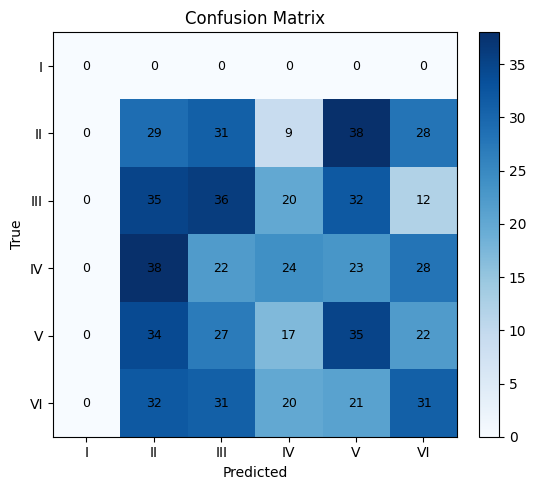

I: recall=0.0000
II: recall=0.2148
III: recall=0.2667
IV: recall=0.1778
V: recall=0.2593
VI: recall=0.2296

Balanced accuracy: 0.1914


In [151]:
import matplotlib.pyplot as plt
import numpy as np

cm = np.load(save_dir / "confmat_val.npy")
classes = ["I","II","III","IV","V","VI"]

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(6)); ax.set_yticks(range(6))
ax.set_xticklabels(classes); ax.set_yticklabels(classes)
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix")
for i in range(6):
    for j in range(6):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=9)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

per_class_recall = cm.diagonal() / np.clip(cm.sum(axis=1), 1, None)
for c, r in zip(classes, per_class_recall):
    print(f"{c}: recall={r:.4f}")
print(f"\nBalanced accuracy: {per_class_recall.mean():.4f}")


In [152]:
# 1A. class distribution and number of examples
print("Total rows:", len(df))
print("Parsed label counts (0..5):")
print(df["_label_idx"].value_counts().sort_index())

# 1B. how many resolved image files exist (if you resolved paths earlier)
# replace PATH_COL with your final path column name (e.g., "resolved_path" or original)
print("Example paths:", df[PATH_COL].head(5).tolist())

# 1C. baseline numbers
num_classes = 6
random_baseline = 1.0/num_classes
majority_class = df["_label_idx"].value_counts().max() / len(df)
print(f"Random baseline: {random_baseline:.3f}; Majority-class baseline: {majority_class:.3f}")


Total rows: 4515
Parsed label counts (0..5):
_label_idx
1    903
2    903
3    903
4    903
5    903
Name: count, dtype: int64
Example paths: ['100.jpg', '1000.jpg', '1000.jpg', '1001.jpg', '10004.jpg']
Random baseline: 0.167; Majority-class baseline: 0.200


In [153]:
# check label dtype and range
print(df["_label_idx"].dtype, df["_label_idx"].min(), df["_label_idx"].max())

# check model final layer dimension
print(model.fc)   # ensure out_features == 6

# check one batch shapes from your DataLoader
for imgs, labels in train_loader:
    print("imgs", imgs.shape, "labels", labels.shape, "labels min/max", labels.min().item(), labels.max().item())
    break


int64 1 5
Linear(in_features=512, out_features=6, bias=True)
imgs torch.Size([64, 3, 224, 224]) labels torch.Size([64]) labels min/max 1 5


In [ ]:
from PIL import Image
from torchvision import transforms

CLASSES = ["I","II","III","IV","V","VI"]

ckpt = torch.load(save_dir / "best_model.pth", map_location=device)
model_inf = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_inf.fc = nn.Linear(model_inf.fc.in_features, 6)
model_inf.load_state_dict(ckpt["state_dict"])
model_inf.eval().to(device)

infer_tf = transforms.Compose([
    transforms.Resize(int(224*1.15)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

@torch.no_grad()
def predict_image(rel_path: str):
    img = Image.open(IMG_ROOT / rel_path).convert("RGB")
    x = infer_tf(img).unsqueeze(0).to(device, non_blocking=True)
    probs = torch.softmax(model_inf(x), dim=1)[0].cpu().numpy()
    idx = int(np.argmax(probs))
    return {"class": CLASSES[idx], "index": idx, "probs": probs.tolist()}

# Example:
# predict_image(df_val.iloc[0][PATH_COL])


C:\Users\yrsee\AppData\Local\Temp\ipykernel_22408\1581629786.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(save_dir / "best_model.pth", map_location=